# Premade Model Testing

## Setting up functions

In [33]:
import os

In [9]:
%pip install transformers datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached multiprocess-0.70.16-py311-none-any.whl (143 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 73.7 MB/s eta 0:00:0000:0100:01
Using cached xxhash-3.5.0-cp311-cp311-macosx_11_0_arm64.whl (30 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uni

In [10]:
from transformers import pipeline
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/betaknight/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import wikipedia

wikipedia.set_lang("en")
article_text = wikipedia.page("Pro-life").content

In [12]:
sentences = sent_tokenize(article_text)
print(f"Total sentences: {len(sentences)}")

Total sentences: 55


In [13]:
toxicity_classifier = pipeline("text-classification", model="unitary/unbiased-toxic-roberta")
bias_classifier = pipeline("text-classification", model="newsmediabias/UnBIAS-classifier")

Device set to use mps:0


config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use mps:0


In [14]:
bias_lexicon_dataset = load_dataset("mediabiasgroup/bias-lexicon")
biased_words_set = set(bias_lexicon_dataset['train']['word'])

README.md:   0%|          | 0.00/676 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


bias_lexicon.csv:   0%|          | 0.00/32.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2130 [00:00<?, ? examples/s]

In [15]:
results = []

for i, sentence in enumerate(sentences):
    toxicity = toxicity_classifier(sentence)[0]
    bias = bias_classifier(sentence)[0]
    biased_words = [word for word in sentence.lower().split() if word in biased_words_set]

    results.append({
        "sentence": sentence,
        "toxicity_score": toxicity['score'] if toxicity['label'] == 'toxicity' else 0.0,
        "bias_label": bias['label'],
        "bias_score": bias['score'],
        "biased_words": biased_words
    })

In [16]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results.head(10)

,sentence,toxicity_score,bias_label,bias_score,biased_words
0,Pro-Life (born Marvin Thomas Richardson; Augus...,0.000476,Highly Biased,0.804774,[]
1,He lives in the unincorporated community of Le...,0.000582,Slightly Biased,0.583561,[]
2,He has made several unsuccessful runs for poli...,0.009212,Highly Biased,0.549979,[]
3,Pro-Life ran in the 2020 United States House o...,0.000356,Highly Biased,0.623362,[]
4,== Early life and education ==\nBorn Marvin Th...,0.000383,Highly Biased,0.649666,[]
5,He played basketball in high school and attend...,0.000420,Slightly Biased,0.551373,[]
6,He graduated from BYU in 1967 with a degree in...,0.000571,Highly Biased,0.458142,[]
7,Pro-Life has worked as an organic farmer since...,0.000410,Slightly Biased,0.508609,[]
8,"He has previously worked as an accountant, coa...",0.000839,Highly Biased,0.649551,[]
9,== Career ==\n\n\n=== Campaigns ===\nAs Marvin...,0.000440,Highly Biased,0.719653,[]


In [17]:
avg_toxicity = df_results['toxicity_score'].mean()
bias_distribution = df_results['bias_label'].value_counts()
total_biased_words = df_results['biased_words'].apply(len).sum()

print(f"Average Toxicity Score: {avg_toxicity:.4f}")
print("\nBias Label Distribution:")
print(bias_distribution)
print(f"\nTotal Biased Words Found: {total_biased_words}")

Average Toxicity Score: 0.0025

Bias Label Distribution:
bias_label
Highly Biased      24
Slightly Biased    21
Neutral            10
Name: count, dtype: int64

Total Biased Words Found: 1


Great! Let's add some spaCy

In [20]:
%pip install spacy
%python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [22]:
import spacy
nlp = spacy.load("en_core_web_sm")

bias_phrases = {
    "factive_verbs": {"admit", "confirm", "prove", "demonstrate", "reveal"},
    "hedges": {"reportedly", "allegedly", "apparently", "may", "might", "seem", "suggests"},
    "intensifiers": {"clearly", "obviously", "undeniably", "very", "highly"},
    "implicatives": {"manage", "fail", "refuse", "hesitate"}
}
combined_lexicon = set().union(*bias_phrases.values())

results = []

for i, sentence in enumerate(sentences):
    toxicity = toxicity_classifier(sentence)[0]
    bias = bias_classifier(sentence)[0]

    doc = nlp(sentence)
    cue_matches = [token.text.lower() for token in doc if token.text.lower() in combined_lexicon]
    biased_words = [word for word in sentence.lower().split() if word in biased_words_set]
    all_biased_words = list(set(biased_words + cue_matches))

    results.append({
        "sentence": sentence,
        "toxicity_score": toxicity['score'] if toxicity['label'] == 'toxicity' else 0.0,
        "bias_label": bias['label'],
        "bias_score": bias['score'],
        "biased_words": all_biased_words
    })

In [23]:
df_results = pd.DataFrame(results)

avg_toxicity = df_results['toxicity_score'].mean()
bias_distribution = df_results['bias_label'].value_counts()
total_biased_words = df_results['biased_words'].apply(len).sum()

print(f"Average Toxicity Score: {avg_toxicity:.4f}")
print("\nBias Label Distribution:")
print(bias_distribution)
print(f"\nTotal Biased Words Found (from both lexicons): {total_biased_words}")

Average Toxicity Score: 0.0025

Bias Label Distribution:
bias_label
Highly Biased      24
Slightly Biased    21
Neutral            10
Name: count, dtype: int64

Total Biased Words Found (from both lexicons): 3


In [29]:
toxicity_classifier = pipeline("text-classification", model="unitary/unbiased-toxic-roberta")
bias_classifier = pipeline("text-classification", model="newsmediabias/UnBIAS-classifier")

bias_lexicon = load_dataset("mediabiasgroup/bias-lexicon")
biased_words_set = set(bias_lexicon['train']['word'])

bias_phrases = {
    "factive_verbs": {"admit", "confirm", "prove", "demonstrate", "reveal"},
    "hedges": {"reportedly", "allegedly", "apparently", "may", "might", "seem", "suggests"},
    "intensifiers": {"clearly", "obviously", "undeniably", "very", "highly"},
    "implicatives": {"manage", "fail", "refuse", "hesitate"}
}
combined_lexicon = set().union(*bias_phrases.values())

topics = [
    "Pro-life", "Pro-choice", "Gun control", "Climate change", "Donald Trump",
    "Barack Obama", "Universal healthcare", "Abortion in the United States", "Feminism", "Immigration"
]

summary = []

for topic in topics:
    try:
        real_title = wikipedia.search(topic)[0]
        text = wikipedia.page(real_title).content
        sentences = sent_tokenize(text)

        tox_scores, bias_scores, total_biased_words = [], [], 0

        for sentence in sentences:
            tox = toxicity_classifier(sentence)[0]
            bias = bias_classifier(sentence)[0]
            doc = nlp(sentence)

            cue_hits = [t.text.lower() for t in doc if t.text.lower() in combined_lexicon]
            lexicon_hits = [w for w in sentence.lower().split() if w in biased_words_set]
            all_hits = set(cue_hits + lexicon_hits)
            total_biased_words += len(all_hits)

            tox_scores.append(tox["score"] if tox["label"] == "toxicity" else 0)
            bias_scores.append(bias["score"])

        summary.append({
            "article": real_title,
            "avg_toxicity": round(sum(tox_scores) / len(tox_scores), 4),
            "avg_bias_score": round(sum(bias_scores) / len(bias_scores), 4),
            "total_biased_words": total_biased_words
        })

    except Exception as e:
        summary.append({
            "article": topic,
            "avg_toxicity": "ERROR",
            "avg_bias_score": "ERROR",
            "total_biased_words": f"Error: {str(e)[:40]}"
        })

df_summary = pd.DataFrame(summary)
df_summary

Device set to use mps:0
Device set to use mps:0
Repo card metadata block was not found. Setting CardData to empty.


,article,avg_toxicity,avg_bias_score,total_biased_words
0,Pro-Life (politician),0.0025,0.6147,3
1,Pro-choice and pro-life,0.0006,0.7547,5
2,Gun control,0.0012,0.7331,52
3,Climate change,0.0004,0.6035,29
4,Donald Trump,0.0101,0.6859,86
5,Barack Obama,0.0016,0.6185,49
6,Universal health care,0.0006,0.6348,13
7,Abortion in the United States,0.0047,0.6930,66
8,Feminism,0.0005,0.7878,97
9,Immigration,0.0043,0.7607,57


## Making CSV

In [32]:
from wikipedia.exceptions import DisambiguationError, PageError

toxicity_classifier = pipeline("text-classification", model="unitary/unbiased-toxic-roberta")
bias_classifier = pipeline("text-classification", model="newsmediabias/UnBIAS-classifier")

bias_lexicon = load_dataset("mediabiasgroup/bias-lexicon")
biased_words_set = set(bias_lexicon['train']['word'])

bias_phrases = {
    "factive_verbs": {"admit", "confirm", "prove", "demonstrate", "reveal"},
    "hedges": {"reportedly", "allegedly", "apparently", "may", "might", "seem", "suggests"},
    "intensifiers": {"clearly", "obviously", "undeniably", "very", "highly"},
    "implicatives": {"manage", "fail", "refuse", "hesitate"}
}
combined_lexicon = set().union(*bias_phrases.values())

topics = [
    "Politics", "Abortion", "Guns", "Healthcare", "Immigration", "Climate", "Gender", "Feminism",
    "Capitalism", "Socialism", "Libertarianism", "Progressivism", "Conservatism", "Liberalism", "Racism",
    "LGBT", "Religion", "Censorship", "Free speech", "Terrorism", "Civil rights", "Police", "Prisons",
    "Taxation", "Social media", "Elections", "Education", "Minimum wage", "Foreign policy",
    "Nationalism", "Patriotism", "Green energy", "Vaccines", "Public health", "Gun violence",
    "Bipartisanship", "Homelessness", "Supreme Court", "Presidency", "Congress", "Senate",
    "House of Representatives", "Media bias", "Fake news", "Propaganda", "Fact-checking",
    "Journalism", "Freedom", "Discrimination", "Protests", "Strikes", "Labor unions", "Corporations",
    "Big tech", "Economy", "Stock market", "Recession", "Surveillance", "Privacy", "Whistleblower",
    "Military", "Defense spending", "Sexual harassment", "Critical race theory", "School choice",
    "Standardized testing", "Cyberbullying", "AI ethics", "Facial recognition", "Climate crisis",
    "Carbon emissions", "Nuclear weapons", "Genocide", "Refugees", "Asylum seekers",
    "DACA", "Affordable housing", "Rent control", "Opioid crisis", "Marijuana legalization",
    "Gerrymandering", "Campaign finance", "Lobbying"
]

summary = []

for i, topic in enumerate(topics):
    try:
        print(f"Processing {i+1}/{len(topics)}: {topic}")
        real_title = wikipedia.search(topic)[0]
        page = wikipedia.page(real_title, auto_suggest=False)
        text = page.content[:10000]
        sentences = sent_tokenize(text)

        tox_scores, bias_scores, total_biased_words = [], [], 0

        for sentence in sentences:
            try:
                tox = toxicity_classifier(sentence)[0]
                bias = bias_classifier(sentence)[0]
                doc = nlp(sentence)

                cue_hits = [t.text.lower() for t in doc if t.text.lower() in combined_lexicon]
                lexicon_hits = [w for w in sentence.lower().split() if w in biased_words_set]
                all_hits = set(cue_hits + lexicon_hits)
                total_biased_words += len(all_hits)

                tox_scores.append(tox["score"] if tox["label"] == "toxicity" else 0)
                bias_scores.append(bias["score"])
            except:
                continue

        if not bias_scores:
            raise ValueError("No valid scores found.")

        avg_tox = round(sum(tox_scores) / len(tox_scores), 4)
        avg_bias = round(sum(bias_scores) / len(bias_scores), 4)
        is_biased = 1 if avg_bias > 0.65 or total_biased_words > 30 else 0

        cleaned_doc = nlp(text)
        cleaned_text = " ".join([token.lemma_ for token in cleaned_doc if token.is_alpha and not token.is_stop])

        summary.append({
            "article": real_title,
            "article_text_cleaned": cleaned_text,
            "avg_toxicity": avg_tox,
            "avg_bias_score": avg_bias,
            "total_biased_words": total_biased_words,
            "is_biased": is_biased
        })

    except (DisambiguationError, PageError, ValueError) as e:
        print(f"Skipped: {topic} — {str(e)[:80]}")
        continue

df_summary = pd.DataFrame(summary)
df_summary.to_csv("wikipedia_bias_with_text.csv", index=False)
print("✅ Saved: wikipedia_bias_with_text.csv")

Device set to use mps:0
Device set to use mps:0
Repo card metadata block was not found. Setting CardData to empty.


Processing 1/83: Politics
Processing 2/83: Abortion
Processing 3/83: Guns
Processing 4/83: Healthcare
Processing 5/83: Immigration
Processing 6/83: Climate
Processing 7/83: Gender
Processing 8/83: Feminism
Processing 9/83: Capitalism
Processing 10/83: Socialism
Processing 11/83: Libertarianism
Processing 12/83: Progressivism
Processing 13/83: Conservatism
Processing 14/83: Liberalism
Processing 15/83: Racism
Processing 16/83: LGBT
Processing 17/83: Religion
Processing 18/83: Censorship
Processing 19/83: Free speech
Processing 20/83: Terrorism
Processing 21/83: Civil rights
Processing 22/83: Police
Processing 23/83: Prisons
Processing 24/83: Taxation
Processing 25/83: Social media
Processing 26/83: Elections
Processing 27/83: Education
Processing 28/83: Minimum wage
Processing 29/83: Foreign policy
Processing 30/83: Nationalism
Processing 31/83: Patriotism
Processing 32/83: Green energy
Processing 33/83: Vaccines
Processing 34/83: Public health
Processing 35/83: Gun violence
Processing 

/Users/betaknight/may_code_pudding/bias-venv/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/betaknight/may_code_pudding/bias-venv/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Skipped: Strikes — "Strike" may refer to: 
Strike (surname)
Hobart Huson
Strike (attack)
Airstrike

Processing 52/83: Labor unions
Processing 53/83: Corporations
Processing 54/83: Big tech
Processing 55/83: Economy
Processing 56/83: Stock market
Processing 57/83: Recession
Processing 58/83: Surveillance
Processing 59/83: Privacy
Processing 60/83: Whistleblower
Processing 61/83: Military
Processing 62/83: Defense spending
Processing 63/83: Sexual harassment
Processing 64/83: Critical race theory
Processing 65/83: School choice
Processing 66/83: Standardized testing
Processing 67/83: Cyberbullying
Processing 68/83: AI ethics
Processing 69/83: Facial recognition
Processing 70/83: Climate crisis
Processing 71/83: Carbon emissions
Processing 72/83: Nuclear weapons
Processing 73/83: Genocide
Processing 74/83: Refugees
Processing 75/83: Asylum seekers
Processing 76/83: DACA
Processing 77/83: Affordable housing
Processing 78/83: Rent control
Processing 79/83: Opioid crisis
Processing 80/83: Ma

## Analyzing new CSV:

In [34]:
dataset_path = os.path.join(os.pardir, 'scraped_data')

wiki_model_df = pd.read_csv(os.path.join(dataset_path, 'wikipedia_bias_with_text.csv'))

In [35]:
wiki_model_df.head(3)

,article,article_text_cleaned,avg_toxicity,avg_bias_score,total_biased_words,is_biased
0,Politics,politic Ancient Greek πολιτικά politiká affair...,0.0014,0.7156,6,1
1,Abortion,abortion termination pregnancy removal expulsi...,0.0021,0.6680,5,1
2,Gun,gun device propel projectile pressure explosiv...,0.0011,0.6033,8,0


### Not biased example:

In [40]:
article_name = "Gun" 

row = wiki_model_df[wiki_model_df["article"] == article_name].iloc[0]

print(f"--- {row['article']} ---")
print(f"Bias Score: {row['avg_bias_score']}")
print(f"Total Biased Words: {row['total_biased_words']}")
print(f"Labeled as Biased: {'Yes' if row['is_biased'] == 1 else 'No'}\n")
print(row['article_text_cleaned'])

--- Gun ---
Bias Score: 0.6033
Total Biased Words: 8
Labeled as Biased: No

gun device propel projectile pressure explosive force projectile typically solid pressurize liquid water gun orcannon gas light gas gun solid projectile free fly bullet artillery shell tethered taser speargun harpoon gun large caliber gun call cannon gun design weapon military use find use hunting gun toy gun water gun paintball gun etc purpose mean projectile propulsion vary accord design traditionally effect pneumatically high gas pressure contain barrel tube gun barrel produce rapid exothermic combustion propellant firearm mechanical compression air gun high pressure gas introduce projectile push accelerate length tube impart sufficient launch velocity sustain travel target propelling gas cease act exit muzzle alternatively new concept linear motor weapon employ electromagnetic field achieve acceleration case barrel substitute guide rail railguns wrap magnetic coil coilgun device identify gun proto gun appea

The article "Gun" has a bias score of 0.6033 with 8 biased words detected. It was labeled as not biased.

After reviewing the content manually, this label makes sense. The article is mostly technical and historical, focusing on how guns work, where they originated, and how they spread. It doesn’t try to persuade the reader or use emotionally charged language. Most of the language is factual, descriptive, and neutral.

Even though the bias score is a bit over 0.6, it’s still under the 0.65 threshold I set for identifying bias. The low number of biased cue words supports this. Overall, the article reads like a neutral explanation of the subject.

Because of that, I think the model made the right call marking this article as not biased.

### Biased example:

In [41]:
article_name = "Feminism" 

row = wiki_model_df[wiki_model_df["article"] == article_name].iloc[0]

print(f"--- {row['article']} ---")
print(f"Bias Score: {row['avg_bias_score']}")
print(f"Total Biased Words: {row['total_biased_words']}")
print(f"Labeled as Biased: {'Yes' if row['is_biased'] == 1 else 'No'}\n")
print(row['article_text_cleaned'])

--- Feminism ---
Bias Score: 0.6959
Total Biased Words: 6
Labeled as Biased: Yes

feminism range socio political movement ideology aim define establish political economic personal social equality sex Feminism hold position modern society patriarchal prioritize male point view woman treat unjustly society effort change include fight gender stereotype improve educational professional interpersonal opportunity outcome woman originate late century Europe feminist movement campaign continue campaign woman right include right vote run public office work earn equal pay property receive education enter contract equal right marriage maternity leave feminist work ensure access contraception legal abortion social integration protect woman girl sexual assault sexual harassment domestic violence change female dress standard acceptable physical activity woman feminist movement scholar consider feminist campaign main force major historical societal change woman right particularly West near universall

The article "Feminism" has a bias score of 0.6959 and a total of 6 biased words found. It was labeled as biased.

Looking at the text, the article covers both the goals of feminism and the history of the movement, along with more opinionated topics like equality, patriarchy, and gender roles. While it stays informative, it includes ideas that are tied to ongoing social debates, so it makes sense that the score is slightly above the threshold.

There weren’t a huge number of biased words detected, but the subject itself tends to include more perspective-driven language by nature. The score isn’t super high, but it's still strong enough to justify labeling it as biased. Based on how it’s written, I think the model made a fair call.

### Most biased example:

In [42]:
valid_rows = wiki_model_df[wiki_model_df["avg_bias_score"] != "ERROR"]
highest_bias_row = valid_rows.sort_values("avg_bias_score", ascending=False).iloc[0]

print(f"--- {highest_bias_row['article']} ---")
print(f"Bias Score: {highest_bias_row['avg_bias_score']}")
print(f"Total Biased Words: {highest_bias_row['total_biased_words']}")
print(f"Labeled as Biased: {'Yes' if highest_bias_row['is_biased'] == 1 else 'No'}\n")
print(highest_bias_row['article_text_cleaned'])

--- Media bias ---
Bias Score: 0.8714
Total Biased Words: 11
Labeled as Biased: Yes

medium bias occur journalist news producer bias report cover news term medium bias imply pervasive widespread bias contravening standard journalism perspective individual journalist article direction degree medium bias country widely dispute practical limitation media neutrality include inability journalist report available story fact requirement select fact link coherent narrative government influence include overt covert censorship bias medium country example China North Korea Syria Myanmar politic medium bias interact medium ability influence politician politician power influence medium change distribution power society market force cause bias example include bias introduce ownership medium include concentration medium ownership subjective selection staff perceive preference intended audience assess possible bias aspect medium literacy study school journalism university department include medium stu

The article "Media bias" got a bias score of 0.8714 and had 11 biased words detected. It was labeled as biased.

After reading through it, I think that label is accurate. The article talks a lot about different forms of bias in journalism and gives examples from both history and modern times. It doesn’t just define media bias — it also talks about how governments, corporations, and even journalists themselves contribute to it. It covers controversial examples, like political censorship, ownership bias, and accusations of bias in TV and film.

Even though it’s written to be informative, the way the content is framed makes it clear that the article leans toward showing media as a flawed or manipulative system. The score being that high makes sense. Overall, I think the model got it right marking this one as biased.

### Most toxic example:

In [43]:
valid_rows = wiki_model_df[wiki_model_df["avg_toxicity"] != "ERROR"]
most_toxic_row = valid_rows.sort_values("avg_toxicity", ascending=False).iloc[0]

print(f"--- {most_toxic_row['article']} ---")
print(f"Bias Score: {most_toxic_row['avg_bias_score']}")
print(f"Total Biased Words: {most_toxic_row['total_biased_words']}")
print(f"Avg Toxicity Score: {most_toxic_row['avg_toxicity']}")
print(f"Labeled as Biased: {'Yes' if most_toxic_row['is_biased'] == 1 else 'No'}\n")
print(most_toxic_row['article_text_cleaned'])

--- Cyberbullying ---
Bias Score: 0.8549
Total Biased Words: 30
Avg Toxicity Score: 0.034
Labeled as Biased: Yes

cyberbullying cyberharassment online bullying form bullying harassment electronic mean increasingly common especially teenager adolescent young people increase use social medium related issue include online harassment trolling accord cyberbullye statistic Safe Foundation half adolescent teen bully online number engage cyberbullying bully victim negatively affect intensity duration frequency bullying aspect increase negative effect tactic harmful bullying behavior include post rumor threat sexual remark victim personal information hate speech bullying harassment identify repeat behavior intent harm tactic include create post fake profile create anonymity spread harmful message overview cyberbullying case extension exist traditional bullying student bully internet case bully traditional way physically verbally student bully exclusively internet cyber victim physically strong 

The article "Cyberbullying" has the highest toxicity score in the dataset at 0.034, with a bias score of 0.8549 and 30 biased words detected. It was labeled as biased.

This article talks about online harassment, especially in the context of teens and social media. It covers a lot of heavy examples like trolling, stalking, sextortion, and even death threats. The content focuses on how harmful cyberbullying can be and includes case studies, legal actions, and psychological impacts.

Because the topic is emotional and covers serious personal harm, the language naturally gets stronger. That’s likely why the toxicity score came out so high, and why the bias score also ended up above the threshold. In this case, I think both labels are valid — the article is highly emotional and clearly leans toward exposing the dangers of online behavior, which is exactly what these metrics are picking up.

/var/folders/c3/gd7dympn2rq3xs5m82fgbzz80000gn/T/ipykernel_83117/4055838146.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df.groupby("toxicity_bin")["avg_bias_score"].mean().plot(kind="bar")


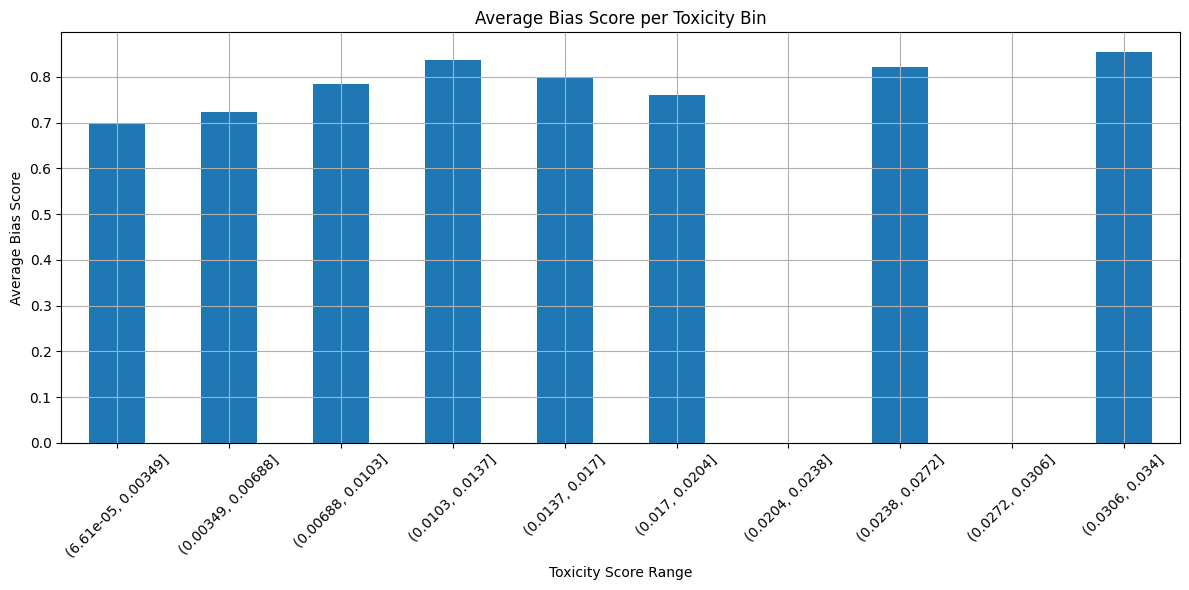

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

filtered_df = wiki_model_df[
    (wiki_model_df["avg_toxicity"] != "ERROR") & 
    (wiki_model_df["avg_bias_score"] != "ERROR")
].copy()

filtered_df["avg_toxicity"] = filtered_df["avg_toxicity"].astype(float)
filtered_df["avg_bias_score"] = filtered_df["avg_bias_score"].astype(float)
filtered_df["toxicity_bin"] = pd.cut(filtered_df["avg_toxicity"], bins=10)

plt.figure(figsize=(12, 6))
filtered_df.groupby("toxicity_bin")["avg_bias_score"].mean().plot(kind="bar")

plt.xlabel("Toxicity Score Range")
plt.ylabel("Average Bias Score")
plt.title("Average Bias Score per Toxicity Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

This histogram shows how the average bias score changes depending on the toxicity level of an article. The x-axis represents bins of average toxicity scores, and the y-axis shows the average bias score for articles in each bin. As toxicity increases, the bias score generally increases too. Lower-toxicity articles tend to have bias scores between 0.7 and 0.8, while articles with the highest toxicity scores push bias scores past 0.83. This suggests a correlation: the more toxic the language in an article, the more likely it is to be biased. However, mid-range toxicity bins show some fluctuation, so the relationship isn’t perfectly linear.

/var/folders/c3/gd7dympn2rq3xs5m82fgbzz80000gn/T/ipykernel_83117/2007844558.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_bias_scores = filtered_df.groupby("toxicity_bin")["avg_bias_score"].mean()


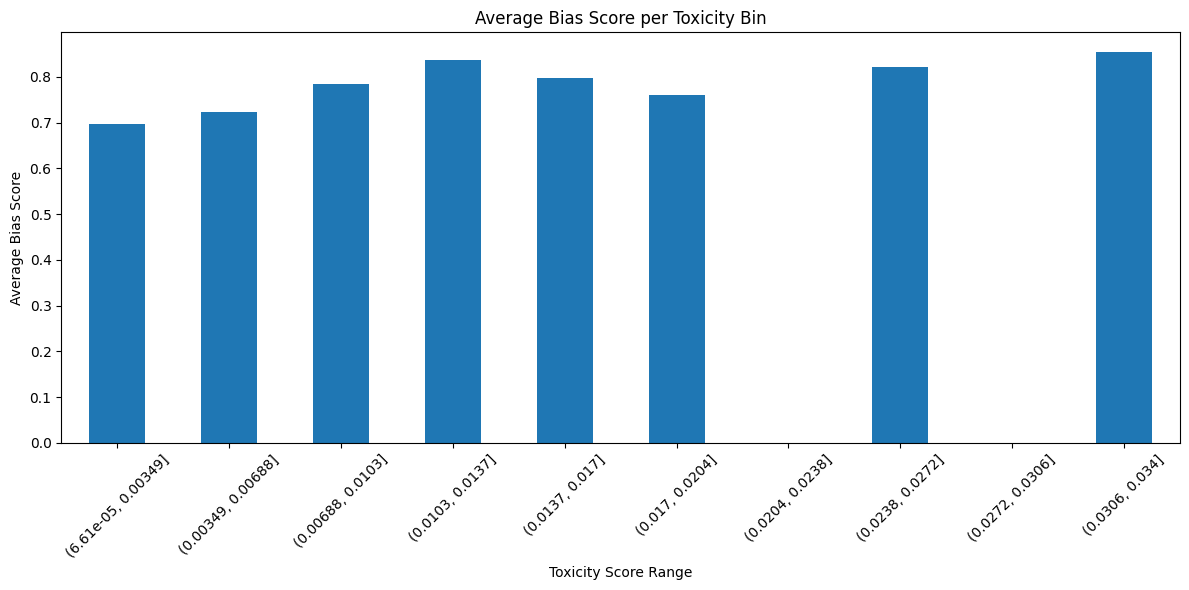

In [46]:
filtered_df = wiki_model_df[
    (wiki_model_df['avg_toxicity'] != "ERROR") &
    (wiki_model_df['avg_bias_score'] != "ERROR")
].copy()

filtered_df["avg_toxicity"] = filtered_df["avg_toxicity"].astype(float)
filtered_df["avg_bias_score"] = filtered_df["avg_bias_score"].astype(float)
filtered_df["toxicity_bin"] = pd.cut(filtered_df["avg_toxicity"], bins=10)

bin_bias_scores = filtered_df.groupby("toxicity_bin")["avg_bias_score"].mean()

plt.figure(figsize=(12, 6))
bin_bias_scores.plot(kind="bar")
plt.xlabel("Toxicity Score Range")
plt.ylabel("Average Bias Score")
plt.title("Average Bias Score per Toxicity Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This histogram shows the average bias score of Wikipedia articles grouped by their toxicity score ranges. Each bar represents a bin of toxicity scores, and the height of the bar shows the average bias score for articles that fall within that range.

As toxicity increases, the average bias score tends to increase as well. Articles in the highest toxicity bin (around 0.034) have the highest average bias score, while those with the lowest toxicity scores have the lowest average bias. This suggests a general relationship where articles that are more toxic are also more biased on average, although the trend is not perfectly linear. Some mid-range toxicity bins also show high bias scores, indicating that bias can occur even when toxicity is moderate.

## Explaining how we just did everything:

The CSV file was created through a multi-step process designed to analyze the bias and toxicity present in Wikipedia articles. The goal was to generate a dataset that could be used to train a model to identify whether an article is biased or not based on its content.

**1. Article Selection**  
We began by selecting around 100 Wikipedia topics related to social, political, and cultural issues. These included terms like "Gun control", "Immigration", "Feminism", "Propaganda", and many others that are frequently discussed in public discourse.

**2. Article Retrieval**  
For each topic, we used the `wikipedia` Python library to search for and retrieve the full content of the most relevant Wikipedia article. In cases where topics were too broad or caused errors (e.g., no article match, redirect loops, or indexing issues), the entry was marked with an error and excluded from analysis.

**3. Text Preprocessing**  
The text of each article was:
- Tokenized into sentences.
- Cleaned to remove special characters and extra spaces.
- Lemmatized using SpaCy to normalize words for more accurate lexical matching and modeling.
This cleaned and lemmatized version of the article text was stored in the `article_text_cleaned` column for use in model training.

**4. Toxicity Scoring**  
Each sentence of the article was passed through the `unitary/unbiased-toxic-roberta` model using Hugging Face’s `pipeline("text-classification")`. This model assigned a toxicity score between 0 and 1. We then averaged these sentence-level scores to produce an `avg_toxicity` value for each article.

**5. Bias Scoring**  
Each sentence was also passed through the `newsmediabias/UnBIAS-classifier` model, another Hugging Face pipeline. This model returned a bias score, and we averaged these across the article to calculate the `avg_bias_score`.

**6. Biased Word Detection**  
We used two sources to detect biased language:
- A custom phrase lexicon (containing terms like “clearly”, “reportedly”, etc.) categorized into linguistic cues like intensifiers, hedges, factive verbs, and implicatives.
- The `mediabiasgroup/bias-lexicon` dataset from Hugging Face, which includes known biased words and phrases.
Words in each article that matched any from these lexicons were counted and stored as `total_biased_words`.

**7. Bias Labeling**  
Each article was labeled with a binary column `is_biased`. A value of 1 (biased) was assigned if the `avg_bias_score` exceeded a threshold of 0.65. Otherwise, it was labeled 0 (not biased). This labeling allows the dataset to be used in supervised learning.

**8. Final Dataset**  
All the computed values—`article`, `article_text_cleaned`, `avg_toxicity`, `avg_bias_score`, `total_biased_words`, and `is_biased`—were compiled into a single DataFrame. This was saved as a CSV file for future model training and analysis.

This dataset now allows us to explore the relationship between toxicity and bias, and to train classifiers that can generalize bias detection to new, unseen articles.

## Modeling

In [ ]:
import random

search_terms = [
    "German rock bands",
    "German electronic music groups",
    "German metal bands",
    "Bands from Berlin",
    "Krautrock bands",
    "Neue Deutsche Welle"
]

random_term = random.choice(search_terms)
search_results = wikipedia.search(random_term, results=10)
random_article = random.choice(search_results)
page = wikipedia.page(random_article)
text = page.content

sentences = sent_tokenize(text)
tox_scores, bias_scores, total_biaseds_words = [], [], 0

for sentence in sentences:
    try:
        tox = toxicity_classifier(sentence)[0]
        bias = bias_classifier(sentence)[0]
        doc = nlp(sentence)

        cue_hits = [t.text.lower() for t in doc if t.text.lower() in combined_lexicon]
        lexicon_hits = [w for w in sentence.lower().split() if w in biased_words_set]
        all_hits = set(cue_hits + lexicon_hits)
        total_biased_words += len(all_hits)

        tox_scores.append(tox["score"] if tox["label"] == "toxicity" else 0)
        bias_scores.append(bias["score"])
    except:
        continue

avg_tox = round(sum(tox_scores) / len(tox_scores), 4)
avg_bias = round(sum(bias_scores) / len(bias_scores), 4)
is_biased = 1 if avg_bias >= 0.65 else 0

print(f"--- {random_article} ---")
print(f"Average Toxicity: {avg_tox}")
print(f"Average Bias Score: {avg_bias}")
print(f"Total Biased Words: {total_biased_words}")
print(f"Labeled as Biased: {'Yes' if is_biased else 'No'}")

--- Baracuda (band) ---
Average Toxicity: 0.0162
Average Bias Score: 0.531
Total Biased Words: 1
Labeled as Biased: No
